## Parameter optimization for accuracy, speed and memory usage
The used dataset is bursi. The following optimizations are computed on Ubuntu 14.04, CPU: Intel i5-6600@3.3GHz, 16 GB RAM
The results are stored in files and only a visualization is done here. The benchmark is computed with the script runBenchmark.sh.

In [1]:
%matplotlib inline
%load_ext memory_profiler
from neighborsMinHash import MinHash
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import time
import math
from collections import Counter
import gc

import os.path
import cPickle as pickle

In [144]:
def compute_score(error_list, memory_list, time_list, max_memory, max_time, alpha, beta):
    score_values = []
    for error_, memory_, time_ in zip(error_list, memory_list, time_list):
        error = error_/(float (max_error))
        if memory_ == 0: 
            score_values.append(5)
            continue
        else:
            memory = math.log(memory_/float(max_memory), 10)*alpha
        time = math.log(time_/float(max_time), 10)*beta
        score_values.append(error + memory  + time)
    score_values_np = np.array(score_values)
    min_values_index = np.array(np.where(score_values_np == score_values_np.min()))
    min_values = score_values_np.min()
    return min_values, min_values_index, score_values

In [168]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
def createPlot(x_values_list, accuracy, time_fit, time_kneighbors, xlabel, ylabelAccuracy, ylabelFit, ylabelKneighbors,
              mean=None, std=None, fig_size=None):
    if fig_size != None:
        plt.figure(figsize=fig_size)
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    if mean != None:
        par3 = host.twinx()
        par3.plot((mean, min(accuracy)), (mean, min(accuracy)), 'k-')
        par4 = host.twinx()
        par4.plot((std, min(accuracy)), (std, min(accuracy)), 'k-')

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.2))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)

    p1, = host.plot(x_values_list, accuracy, "b-")
    p2, = par1.plot(x_values_list, time_fit, "r-")
    p3, = par2.plot(x_values_list, time_kneighbors, "g-")

    host.set_xlim(min(x_values_list), max(x_values_list))
    host.set_ylim(min(accuracy), max(accuracy))
    par1.set_ylim(min(time_fit), max(time_fit))
    par2.set_ylim(min(time_kneighbors), max(time_kneighbors))

    host.set_xlabel(xlabel)
    host.set_ylabel(ylabelAccuracy)
    par1.set_ylabel(ylabelFit)
    par2.set_ylabel(ylabelKneighbors)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]
    plt.show()

### Distribution of the inverse index

In [11]:
input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/init_values"
if os.path.isfile(input_file_name):
    fileObject = open(input_file_name,'r')
    distribution = pickle.load(fileObject)

#     print distribution[0][0]

{0: 4258, 1: 196269, 2: 47495, 3: 21643, 4: 12090, 5: 8002, 6: 5855, 7: 4339, 8: 3294, 9: 2592, 10: 2150, 11: 1775, 12: 1485, 13: 1302, 14: 1104, 15: 1007, 16: 822, 17: 756, 18: 633, 19: 601, 20: 577, 21: 448, 22: 456, 23: 459, 24: 412, 25: 338, 26: 308, 27: 269, 28: 291, 29: 263, 30: 225, 31: 246, 32: 217, 33: 199, 34: 194, 35: 183, 36: 163, 37: 165, 38: 154, 39: 175, 40: 131, 41: 107, 42: 118, 43: 101, 44: 132, 45: 113, 46: 105, 47: 91, 48: 86, 49: 90, 50: 97}


In [12]:
# distribution = n_neighbors_minHash.get_distribution_of_inverse_index()
min_ = min(distribution[0][0])
max_ = max(distribution[0][0])

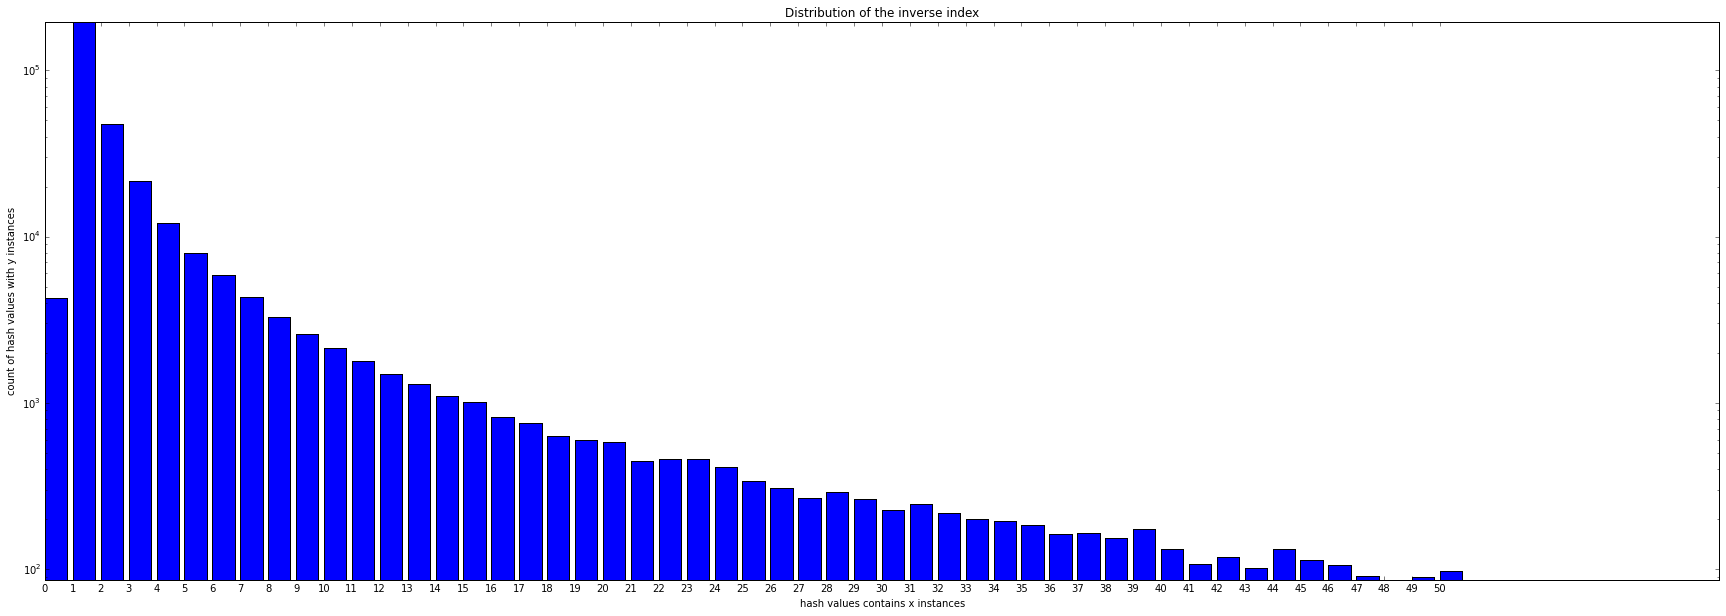

In [14]:
X = np.arange(len(distribution[0][0]))
plt.figure(figsize=(30, 10))
plt.yscale('log')
plt.bar(X, distribution[0][0].values())
plt.xticks(X, distribution[0][0].keys())
ymax = max(distribution[0][0].values())
plt.ylim(0, ymax)
plt.ylabel("count of hash values with y instances")
plt.xlabel("hash values contains x instances")
plt.title("Distribution of the inverse index")
plt.show()

### Compute the maximum values for time, memory usage and the error value

In [64]:
max_error = 1 - distribution[3]
max_time = distribution[2]
memory_list = []
max_memory = 0
for i in distribution[0][0]:
    memory_list.append(distribution[0][0][i])
    max_memory += distribution[0][0][i]


### Best pruning value for the frequency of occurences of hash values

In [51]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
for i in xrange(1, 10):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/prune_index_frequencey+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        distribution_pruning.append(pickle.load(fileObject))
        error_list.append(1 - distribution_pruning[i-index_shift][3])
        time_fit_list.append(distribution_pruning[i-index_shift][1])
        time_kneighbors_list.append(distribution_pruning[i-index_shift][2])
    else:
        ++index_shift
print len(distribution_pruning)
# print distribution_pruning

9


In [56]:
memory_list = []
for dist in distribution_pruning:
    memory = 0
    for j in dist[0][0]:
        memory += dist[0][0][j]
    memory_list.append(memory)

[123858, 76363, 54720, 42630, 34628, 28773, 24434, 21140, 18548]


#### Stored elements in the inverse index after pruning hash values with an occurence less than n

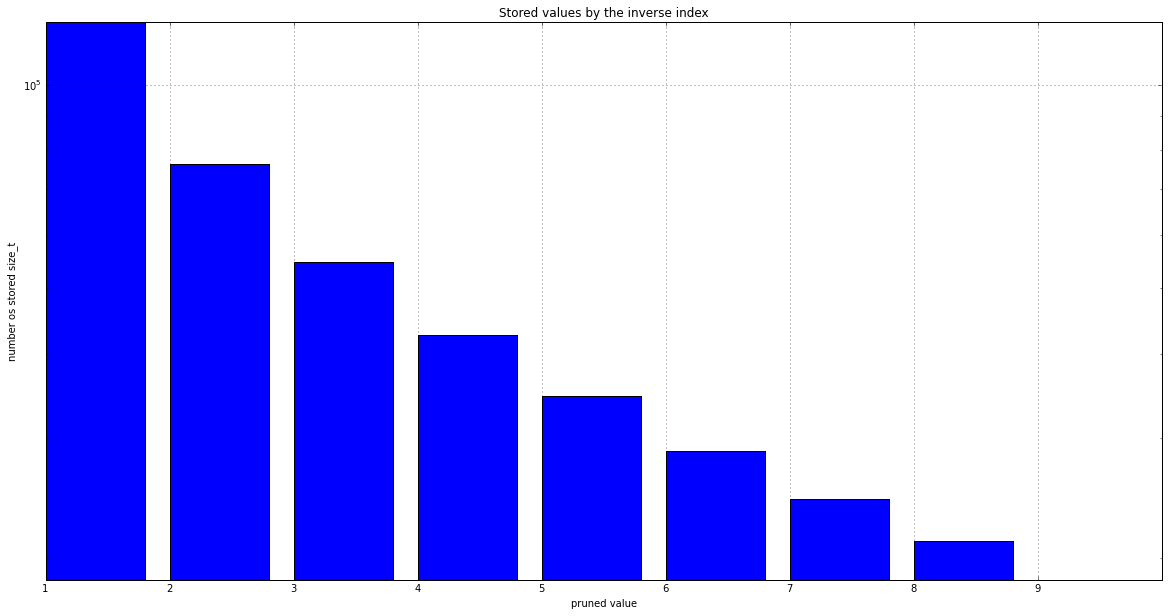

In [57]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, range(1, 10))
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number os stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time under the aspect of pruning of the inverse index

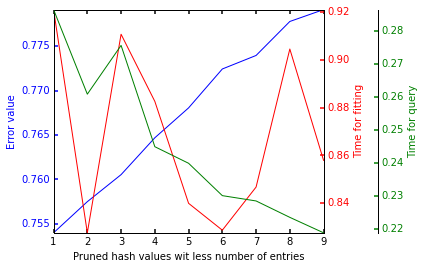

In [58]:
createPlot(range(1,10), error_list, time_fit_list, time_kneighbors_list,
           "Pruned hash values wit less number of entries", "Error value",
           "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [65]:
min_error_value = 1
best_alpha = 0
best_beta = 0
best_score = 0
best_pruning_value = 0
epsilon = 0.05 # allow a variance of factor epsilon for the error value
plotting_values=[[]] # score, error, alpha, beta
for alpha_ in np.arange(0.01, 2 ,2):
    for beta_ in np.arange(0.01, 2, 0.01):
        result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
#         print error_list[result[1][0][0]]
        if max_error + epsilon > error_list[result[1][0][0]]:
            if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                best_score = result[0]
                best_alpha = alpha_
                best_beta = beta_
                min_error_value = error_list[result[1][0][0]]
                best_pruning_value = result[1][0][0]
                plotting_values.append([best_score, min_error_value, best_alpha, best_beta])
            
print "alpha: ", best_alpha
print "beta: ", best_beta
print "Error value: ", min_error_value
print "Best pruning value: ", best_pruning_value
print "Score: ", best_score

alpha:  0.01
beta:  1.99
Error value:  0.757482130505
Best pruning value:  1
Score:  2.0474475984


#### Optimization for memory usage and speed

Best value for pruning:  0  with value:  0.961228629232


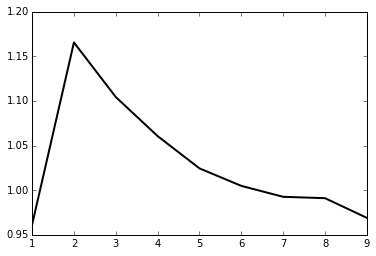

In [67]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.13, beta=0.36)
# print result
plt.plot(range(1,10), result[2], 'k-', lw=2)
print "Best value for pruning: ", result[1][0][0], " with value: ", result[0]

### Removing hash functions with less hash values than n

In [82]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
iteration_value = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
#  = [85 328 434 496 522 579 608 641 658 679 705 716 733 757 765 778 793 808 817 829 840 853 868 882 891 900 912 920 927 940 953 962 973 989 998 1023 1045 1065 1092 1126]
for i in iteration_value:
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_function_pruned+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])

# print len(distribution_pruning)
# print distribution_pruning

In [83]:
memory_list = []
for dist in distribution_pruning:
    memory = 0
    for j in dist[0][0]:
        memory += dist[0][0][j]
    memory_list.append(memory)

#### Stored elements in the inverse index after pruning

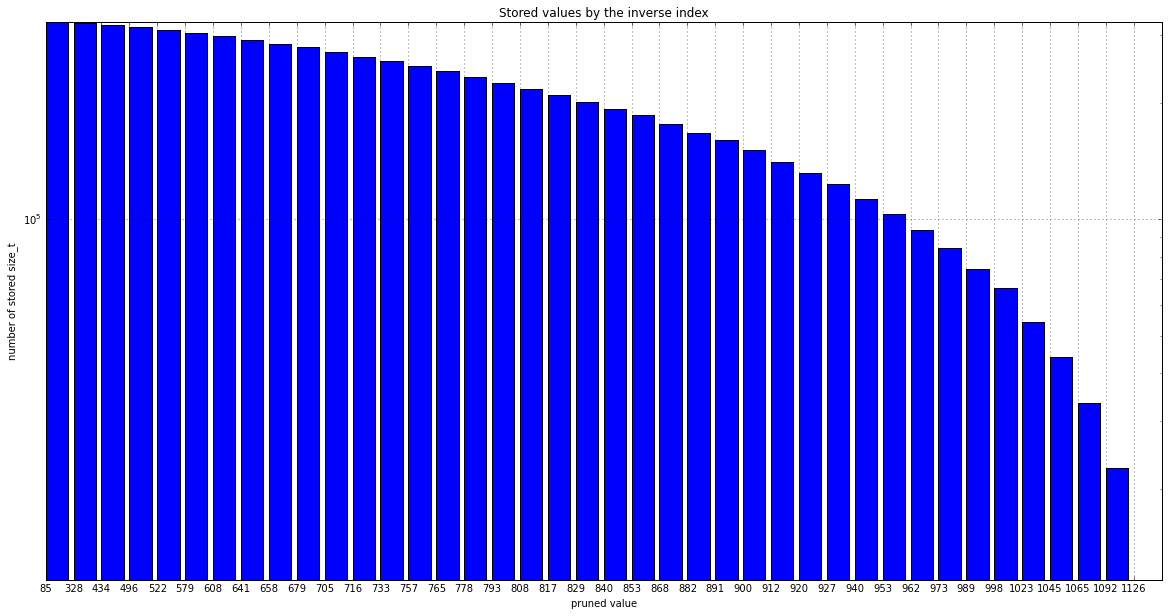

In [84]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time under the aspect of pruning of the inverse index

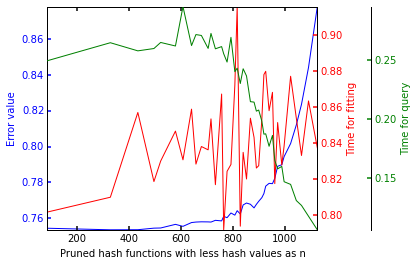

In [85]:
createPlot(iteration_value, error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [93]:
min_error_value = 1
best_alpha = 0
best_beta = 0
best_score = 0
best_pruning_value = 0
epsilon = 0.05 # allow a variance of factor epsilon for the error value
score_list = []
alpha_list = []
beta_list = []
pruning_value_list = []
for alpha_ in np.arange(0.01, 2 ,0.01):
    for beta_ in np.arange(0.01, 2, 0.01):
        result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
#         print error_list[result[1][0][0]]
#         search_steps = [result, alpha_, beta_]
        if max_error + epsilon > error_list[result[1][0][0]]:
            score_list.append(result[0])
            alpha_list.append(alpha_)
            beta_list.append(beta_)
            pruning_value_list.append(iteration_value[result[1][0][0]])
            if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                best_score = result[0]
                best_alpha = alpha_
                best_beta = beta_
                min_error_value = error_list[result[1][0][0]]
                best_pruning_value = result[1][0][0]
            
print "alpha: ", best_alpha
print "beta: ", best_beta
print "Error value: ", min_error_value
print "Best pruning value: ", iteration_value[best_pruning_value]
print "Score: ", best_score

alpha:  0.15
beta:  1.99
Error value:  0.7622780724
Best pruning value:  829
Score:  1.98898262276


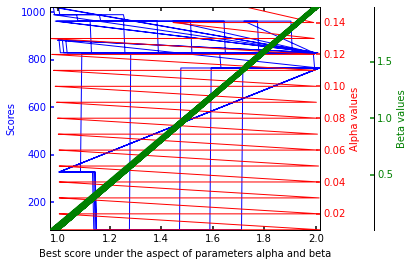

In [96]:

createPlot(score_list, pruning_value_list,  alpha_list, beta_list, 
           "Best score under the aspect of parameters alpha and beta",
           "Scores", "Alpha values", "Beta values")

#### Optimization for memory usage and speed

Best value for pruning:  829  with value:  1.99311583723


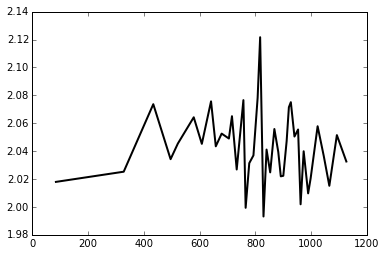

In [90]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.13, beta=1.99)
# print result
plt.plot(iteration_value, result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value[result[1][0][0]], " with value: ", result[0]

### Influence of shingels

#### Concaternate values of a shingleton

In [111]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1

for i in xrange(1, 6):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/shingle+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])

# print len(distribution_pruning)
# print distribution_pruning
print error_list

[0.7542079778648797, 0.74166474521558168, 0.76458381369609962, 0.79598801014525855, 0.82766889554991752]


In [107]:
memory_list = []
for dist in distribution_pruning:
    memory = 0
    for j in dist[0][0]:
        memory += dist[0][0][j]
    memory_list.append(memory)
print memory_list

[324385, 410218, 389408, 342851, 297135]


#### Stored elements in the inverse index

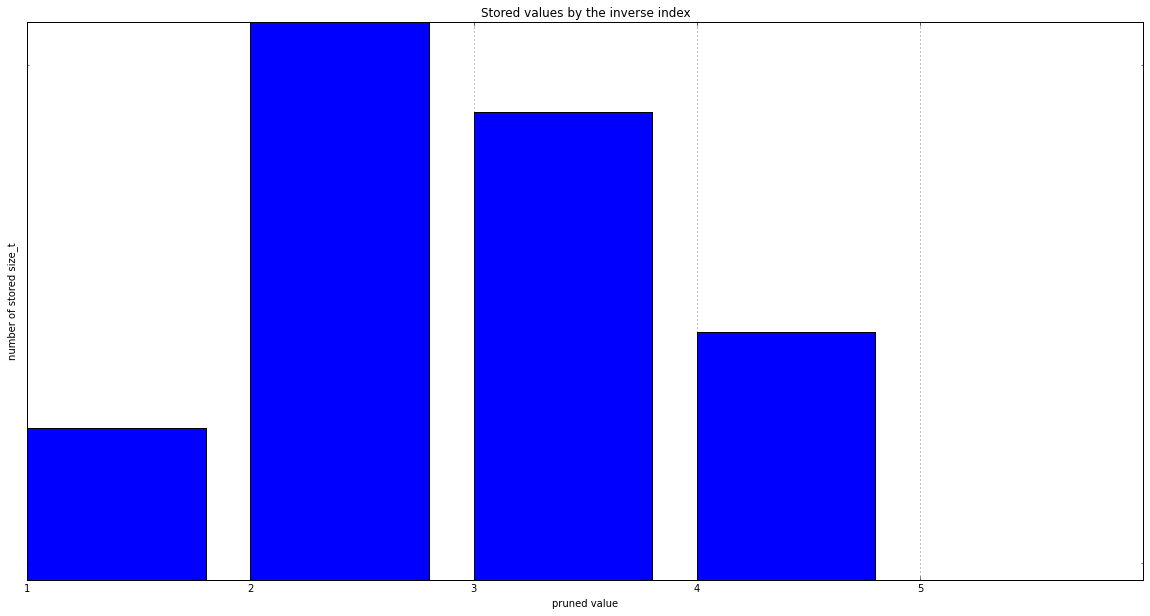

In [108]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, range(1, 6))
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

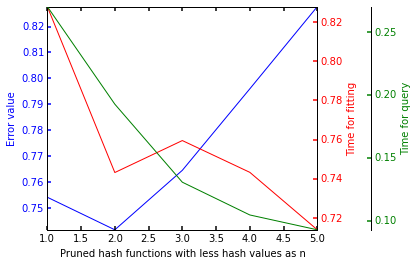

In [112]:
createPlot(range(1,6), error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [113]:
min_error_value = 1
best_alpha = 0
best_beta = 0
best_score = 0
best_pruning_value = 0
epsilon = 0.05 # allow a variance of factor epsilon for the error value
for alpha_ in np.arange(0.01, 2 ,0.01):
    for beta_ in np.arange(0.01, 2, 0.01):
        result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
#         print error_list[result[1][0][0]]
        if max_error + epsilon > error_list[result[1][0][0]]:
            if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                best_score = result[0]
                best_alpha = alpha_
                best_beta = beta_
                min_error_value = error_list[result[1][0][0]]
                best_pruning_value = result[1][0][0]
            
print "alpha: ", best_alpha
print "beta: ", best_beta
print "Error value: ", min_error_value
print "Best pruning value: ", best_pruning_value
print "Score: ", best_score

alpha:  1.99
beta:  0.33
Error value:  0.754207977865
Best pruning value:  0
Score:  1.17375937453


#### Optimization for memory usage and speed

Best value for pruning:  1  with value:  1.16926544451


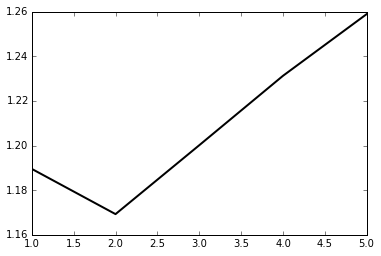

In [114]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.13, beta=0.36)
# print result
plt.plot(range(1,6), result[2], 'k-', lw=2)
print "Best value for pruning: ", result[1][0][0], " with value: ", result[0]

#### Take minimum value of shingelton

#### Stored elements in the inverse index

#### Error value, fitting time and query time

#### Optimization for alpha and beta with respect to a minimal error value

#### Optimization for memory usage and speed

### Frequencey of pruning

#### Removing hash functions with less hash values than n

In [118]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
frequency_pruning = [0.1, 0.3, 0.5, 0.7, 1]

for i in frequency_pruning:
    for j in xrange(1, 10):
        input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/freqency_pruning_and_occurences+"+str(i)+ "+" +str(j)
        if os.path.isfile(input_file_name):
            fileObject = open(input_file_name,'r')
            dist_tmp = pickle.load(fileObject)
            distribution_pruning.append(dist_tmp)
            error_list.append(1 - dist_tmp[3])
            time_fit_list.append(dist_tmp[1])
            time_kneighbors_list.append(dist_tmp[2])

# print len(distribution_pruning)
# print distribution_pruning
print error_list

[0.86340788563523296, 0.89637998616555503, 0.92294212589347635, 0.93677657366843547, 0.94599953885174148, 0.95559142264237984, 0.9587272308047039, 0.96260087618169243, 0.96287756513719169, 0.85169471985243284, 0.87876412266543946, 0.90131427253862351, 0.91524094996541572, 0.9313350242102848, 0.94217200830066949, 0.94839750979940107, 0.95051879179156151, 0.95941895319345194, 0.76467604334793315, 0.77666589808623199, 0.78307585888862963, 0.78851740834678052, 0.79916993313349982, 0.80613327184689598, 0.81074475443854987, 0.81701637076319877, 0.82384136499884564, 0.80193682268849253, 0.80963799861655328, 0.8205210975328554, 0.82988240719391182, 0.84173391745446113, 0.84818999308277609, 0.85939589578049436, 0.86433018215356416, 0.87498270694028402, 0.75397740373529698, 0.75720544154945468, 0.76126354623010961, 0.76476827299976624, 0.76781185151025777, 0.7725616785796604, 0.77412958266082266, 0.77735762047498025, 0.7797555914226395]


In [120]:
memory_list = []
for dist in distribution_pruning:
    memory = 0
    for j in dist[0][0]:
        memory += dist[0][0][j]
    memory_list.append(memory)
print memory_list

[60742, 26208, 15343, 9987, 7059, 5398, 4034, 3104, 2566, 86453, 45240, 29396, 21198, 16314, 12761, 10429, 8623, 7158, 101129, 56495, 38078, 27929, 21636, 17323, 14211, 11900, 10085, 106322, 61918, 43113, 32940, 26482, 21778, 18521, 16002, 14016, 123858, 76363, 54720, 42630, 34628, 28773, 24434, 21140, 18548]


#### Stored elements in the inverse index

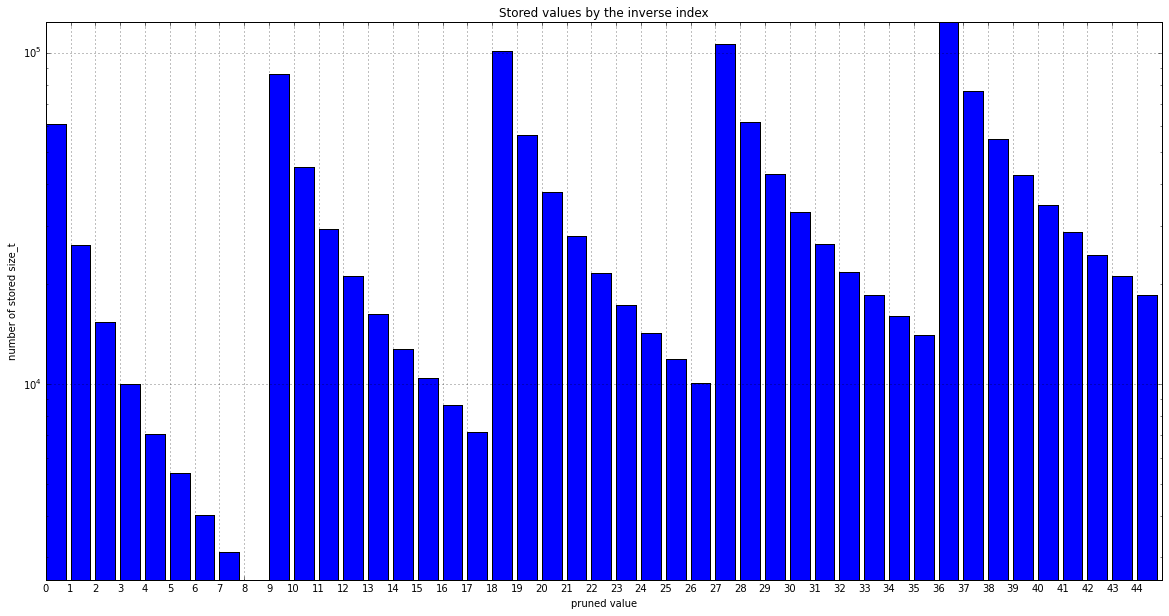

In [121]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, range(0, 50))
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

In [124]:
print len(range(0, 45))
print len(error_list)
print len(time_fit_list)
print len(time_kneighbors_list)

45
45
45
45


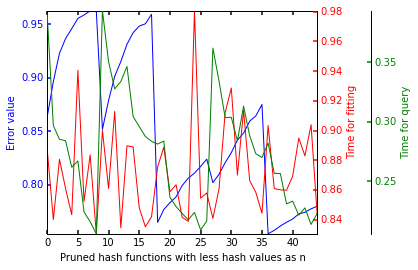

In [125]:
createPlot(range(0, 45), error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [126]:
min_error_value = 1
best_alpha = 0
best_beta = 0
best_score = 0
best_pruning_value = 0
epsilon = 0.05 # allow a variance of factor epsilon for the error value
for alpha_ in np.arange(0.01, 2 ,0.01):
    for beta_ in np.arange(0.01, 2, 0.01):
        result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
#         print error_list[result[1][0][0]]
        if max_error + epsilon > error_list[result[1][0][0]]:
            if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                best_score = result[0]
                best_alpha = alpha_
                best_beta = beta_
                min_error_value = error_list[result[1][0][0]]
                best_pruning_value = result[1][0][0]
            
print "alpha: ", best_alpha
print "beta: ", best_beta
print "Error value: ", min_error_value
print "Best pruning value: ", best_pruning_value
print "Score: ", best_score

alpha:  0.26
beta:  1.99
Error value:  0.779755591423
Best pruning value:  44
Score:  1.77233277346


#### Optimization for memory usage and speed

Best value for pruning:  44  with value:  1.06472100406


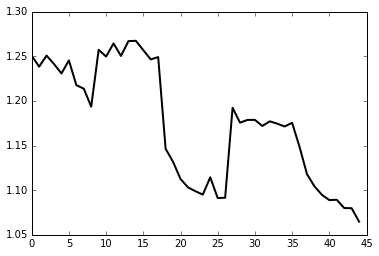

In [128]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.13, beta=0.36)
# print result
plt.plot(range(0,45), result[2], 'k-', lw=2)
print "Best value for pruning: ", result[1][0][0], " with value: ", result[0]

#### Best pruning value for the frequency of occurences of hash values

In [152]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
index_values = []
frequency_pruning = [0.1, 0.3, 0.5, 0.7, 1]
iteration_value_list = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
for i in frequency_pruning:
    for j in iteration_value:
        
        input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/frequencey_pruning_and_size_hash_values+"+str(i)+ "+" +str(j)
        if os.path.isfile(input_file_name):
            fileObject = open(input_file_name,'r')
            dist_tmp = pickle.load(fileObject)
            distribution_pruning.append(dist_tmp)
            error_list.append(1 - dist_tmp[3])
            time_fit_list.append(dist_tmp[1])
            time_kneighbors_list.append(dist_tmp[2])
            iteration_value_list.append([i,j])

# print len(distribution_pruning)
# print distribution_pruning
# print error_list

In [153]:
memory_list = []
for dist in distribution_pruning:
    memory = 0
    for j in dist[0][0]:
        memory += dist[0][0][j]
    memory_list.append(memory)
tmp_memory = []
tmp_index = []
tmp_fitting_time = []
tmp_query_time = []
tmp_error_list = []
for i in xrange(len(memory_list)):
    if memory_list[i] != 0:
        tmp_memory.append(memory_list[i])
        tmp_index.append(iteration_value_list[i])
        tmp_fitting_time.append(time_fit_list[i])
        tmp_error_list.append(error_list[i])
        tmp_query_time.append(time_kneighbors_list[i])
memory_list = tmp_memory
iteration_value_list = tmp_index
time_fit_list = tmp_fitting_time
error_list = tmp_error_list
time_kneighbors_list = tmp_query_time
print memory_list


[321397, 321397, 321397, 323974, 323974, 323974, 269575, 269575, 269575, 122352, 122352, 122352, 36298, 36298, 36298, 12878, 12878, 12878, 1335, 1335, 1335, 1335, 1335, 1335, 324059, 324059, 324059, 312869, 312869, 312869, 283286, 283286, 283286, 244060, 244060, 244060, 222810, 222810, 222810, 159665, 159665, 159665, 117342, 117342, 117342, 73565, 73565, 73565, 62615, 62615, 62615, 42748, 42748, 42748, 25450, 25450, 25450, 21028, 21028, 21028, 12945, 12945, 12945, 2881, 2881, 2881, 2883, 2883, 2883, 2113, 2113, 2113, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 873, 873, 873, 324102, 324102, 324102, 319147, 319147, 319147, 304263, 304263, 304263, 289661, 289661, 289661, 280414, 280414, 280414, 252782, 252782, 252782, 230596, 230596, 230596, 207268, 207268, 207268, 196517, 196517, 196517, 173423, 173423, 173423, 145757, 145757, 145757, 131233, 131233, 131233, 111795, 111795, 111795, 87991, 87991, 87991, 80200, 80200, 80200, 

#### Stored elements in the inverse index

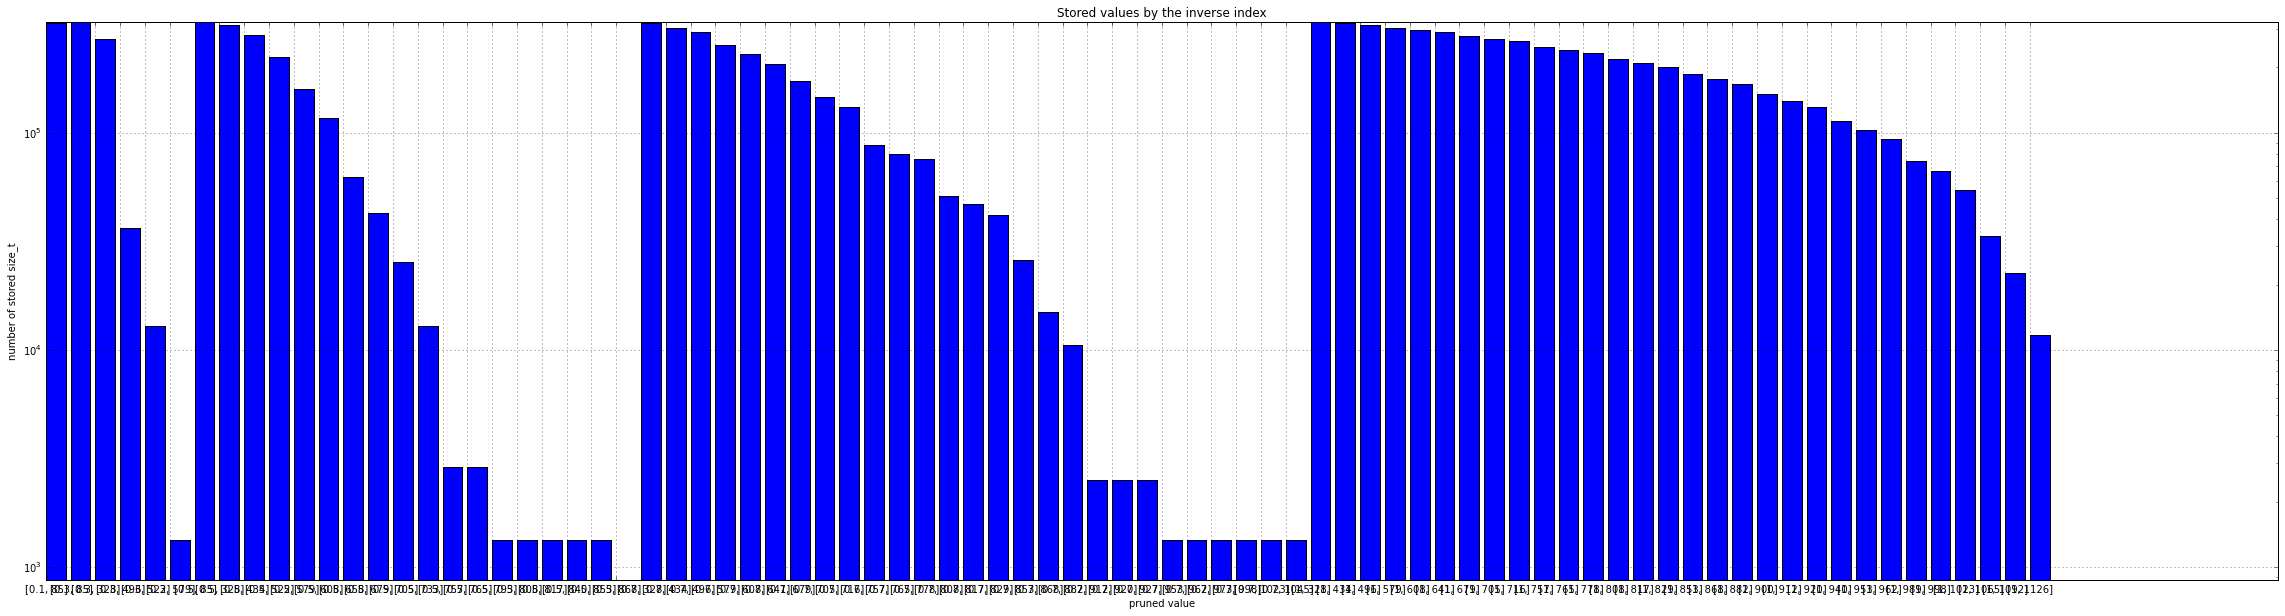

In [165]:
data = np.arange(len(memory_list[0::4]))
plt.figure(figsize=(40, 10))
plt.width=1
plt.yscale('log')
plt.bar(data, memory_list[0::4])
plt.xticks(data, iteration_value_list[0::4])
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

In [166]:
print len(range(0, len(iteration_value_list)))
print len(error_list)
print len(time_fit_list)
print len(time_kneighbors_list)

321
321
321
321


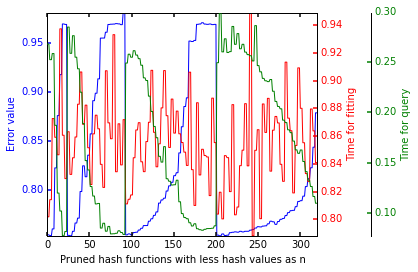

In [170]:
createPlot(range(0, len(iteration_value_list)), error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [171]:
min_error_value = 1
best_alpha = 0
best_beta = 0
best_score = 0
best_pruning_value = 0
epsilon = 0.05 # allow a variance of factor epsilon for the error value
for alpha_ in np.arange(0.01, 2 ,0.01):
    for beta_ in np.arange(0.01, 2, 0.01):
        result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
#         print error_list[result[1][0][0]]
        if max_error + epsilon > error_list[result[1][0][0]]:
            if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                best_score = result[0]
                best_alpha = alpha_
                best_beta = beta_
                min_error_value = error_list[result[1][0][0]]
                best_pruning_value = result[1][0][0]
            
print "alpha: ", best_alpha
print "beta: ", best_beta
print "Error value: ", min_error_value
print "Best pruning value: ", best_pruning_value
print "Score: ", best_score

alpha:  0.13
beta:  1.99
Error value:  0.759787871801
Best pruning value:  243
Score:  1.99373760736


#### Optimization for memory usage and speed

Best value for pruning:  [1, 765]  with value:  1.99373760736


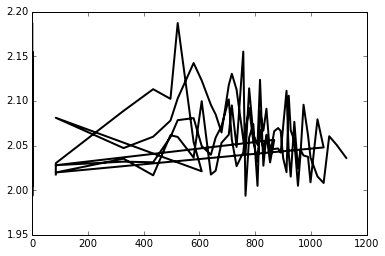

In [174]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.13, beta=1.99)
# print result
plt.plot(iteration_value_list, result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value_list[result[1][0][0]], " with value: ", result[0]

### All methods together

In [180]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
index_values = []
frequency_pruning = [0.5, 0.7, 1]
iteration_value_list = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
for i in frequency_pruning:
    for j in xrange(1, 10):
        for k in iteration_value:
            for l in xrange(1,6):
                input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/all+"+str(i)+ "+" +str(j)+ "+" +str(k)+ "+" +str(l)
                if os.path.isfile(input_file_name):
                    fileObject = open(input_file_name,'r')
                    dist_tmp = pickle.load(fileObject)
                    distribution_pruning.append(dist_tmp)
                    error_list.append(1 - dist_tmp[3])
                    time_fit_list.append(dist_tmp[1])
                    time_kneighbors_list.append(dist_tmp[2])
                    iteration_value_list.append([i,j])
# print error_list

In [177]:
memory_list = []
for dist in distribution_pruning:
    memory = 0
    for j in dist[0][0]:
        memory += dist[0][0][j]
    memory_list.append(memory)
tmp_memory = []
tmp_index = []
tmp_fitting_time = []
tmp_query_time = []
tmp_error_list = []
for i in xrange(len(memory_list)):
    if memory_list[i] != 0:
        tmp_memory.append(memory_list[i])
        tmp_index.append(iteration_value_list[i])
        tmp_fitting_time.append(time_fit_list[i])
        tmp_error_list.append(error_list[i])
        tmp_query_time.append(time_kneighbors_list[i])
memory_list = tmp_memory
iteration_value_list = tmp_index
time_fit_list = tmp_fitting_time
error_list = tmp_error_list
time_kneighbors_list = tmp_query_time
print memory_list

[]


#### Stored elements in the inverse index

In [ ]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, range(max(distribution_inverse_index_max[0][0].iterkeys())))
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.ylabel("number os stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

In [ ]:
createPlot(sorted(distribution[1]), error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [ ]:
min_error_value = 1
best_alpha = 0
best_beta = 0
best_score = 0
best_pruning_value = 0
epsilon = 0.05 # allow a variance of factor epsilon for the error value
for alpha_ in np.arange(0.01, 2 ,0.01):
    for beta_ in np.arange(0.01, 2, 0.01):
        result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
#         print error_list[result[1][0][0]]
        if max_error + epsilon > error_list[result[1][0][0]]:
            if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                best_score = result[0]
                best_alpha = alpha_
                best_beta = beta_
                min_error_value = error_list[result[1][0][0]]
                best_pruning_value = result[1][0][0]
            
print "alpha: ", best_alpha
print "beta: ", best_beta
print "Error value: ", min_error_value
print "Best pruning value: ", best_pruning_value
print "Score: ", best_score

#### Optimization for memory usage and speed

In [ ]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.13, beta=0.36)
# print result
plt.plot(range(max(distribution_inverse_index_max[0][0].iterkeys())+1), result[2], 'k-', lw=2)
print "Best value for pruning: ", result[1][0][0], " with value: ", result[0]